In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

## Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [4]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
evo_data.fillna(0, inplace=True)
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
modo_data.fillna(0, inplace=True)
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]
#c2g_data.fillna(0, inplace=True)

In [5]:
def train_size(data, size=0.7):
    # 70% of the data to use as train set
    train_split = int(len(data) * size)
    return train_split

In [6]:
def norm_data(features, train_split):
    dataset = features.values
    data_max = dataset[:train_split].max()
    data_min = dataset[:train_split].min()
    data_std = dataset[:train_split].std(axis=0)

    dataset = (dataset-data_min)/(data_max - data_min)
    
    return dataset

In [7]:
modo_norm = norm_data(modo_data, train_size(modo_data))
evo_norm = norm_data(evo_data, train_size(evo_data))
c2g_norm = norm_data(c2g_data, train_size(c2g_data))

## LSTM Data preparation

For this analysis the aim is to predict the number of travels using a multivariate LSTM model

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Reshape the data to usual representation of train and target sets
    
    single_step - In a single step setup (True), the model learns to predict a single point in the future 
                  based on some history provided. Else (False), the model needs to learn to predict a range 
                  of future values.
    
    target_size - Is how far in the future does the model need to learn to predict.
                  The target_size is from the label that needs to be predicted
    """
    data = []
    labels = []

    start_index = start_index + history_size # determining the real start since it has a history size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # creating the data 'chuncks' with size of history size
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step: # selecting the point or interval to be predicted
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [9]:
def train_val_split(data, train_split, history_length=72, future_target=1, 
                    step=1, single_step=False, batch_size=256, buffer_size=10000):

    # splitting the train and evaluate sets
    x_train, y_train = multivariate_data(data, data[:, 0], 0, train_split, history_length, future_target, step, single_step)
    x_val, y_val = multivariate_data(data, data[:, 0], train_split, None, history_length, future_target, step, single_step)

    print ('Single window of past history : {}'.format(x_train[0].shape))
    print ('\n Target feature to predict : {}'.format(y_train[0].shape))
    
    # slice and shuffle the train and evaluate sets based on the batch size
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val = val.batch(batch_size).repeat()
    
    shape = x_train.shape[-2:]
    
    return train, val, shape

In [10]:
def lstm_model(train_data, validation_data, shape, epochs=10, evaluation_interval=200):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(44, return_sequences=True,
                                  input_shape=shape))
    model.add(tf.keras.layers.LSTM(28, activation='relu'))
    model.add(tf.keras.layers.Dense(12))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                  loss='mae',
                  metrics=["accuracy"])

    for x, y in validation_data.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train_data, epochs=epochs,
                      steps_per_epoch=evaluation_interval,
                      validation_data=validation_data,
                      validation_steps=50)
    
    return model, history

In [11]:
# split data on train and validate sets
evo_train, evo_val, evo_shape = train_val_split(data=evo_norm, train_split=train_size(evo_norm), history_length=24, future_target=12)
modo_train, modo_val, modo_shape = train_val_split(data=modo_norm, train_split=train_size(modo_norm), history_length=24, future_target=12)
c2g_train, c2g_val, c2g_shape = train_val_split(data=c2g_norm, train_split=train_size(c2g_norm), history_length=24, future_target=12)

Single window of past history : (24, 44)

 Target feature to predict : (12,)
Single window of past history : (24, 44)

 Target feature to predict : (12,)
Single window of past history : (24, 44)

 Target feature to predict : (12,)


# Training Models

In [29]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [16]:
def plot_train_history(history, title):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)

    plt.show()

Next, will be generated the model for each dataset

## Evo Model

In [17]:
print('Evo Model')
evo_model, evo_history = lstm_model(evo_train, evo_val, evo_shape, epochs=20)

Evo Model
(43, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 19s 94ms/step - loss: 0.1368 - accuracy: 0.1331 - val_loss: 0.1188 - val_accuracy: 0.1395
Epoch 2/20
200/200 [==============================] - 12s 59ms/step - loss: 0.1044 - accuracy: 0.1795 - val_loss: 0.1124 - val_accuracy: 0.2791
Epoch 3/20
200/200 [==============================] - 14s 72ms/step - loss: 0.0893 - accuracy: 0.2067 - val_loss: 0.1103 - val_accuracy: 0.1860
Epoch 4/20
200/200 [==============================] - 14s 71ms/step - loss: 0.0817 - accuracy: 0.2400 - val_loss: 0.1094 - val_accuracy: 0.2791
Epoch 5/20
200/200 [==============================] - 15s 73ms/step - loss: 0.0759 - accuracy: 0.2599 - val_loss: 0.1037 - val_accuracy: 0.3023
Epoch 6/20
200/200 [==============================] - 15s 73ms/step - loss: 0.0710 - accuracy: 0.2700 - val_loss: 0.1044 - val_accuracy: 0.3256
Epoch 7/20
200/200 [==============================] - 17s 83ms/step - loss

### Plotting prediction

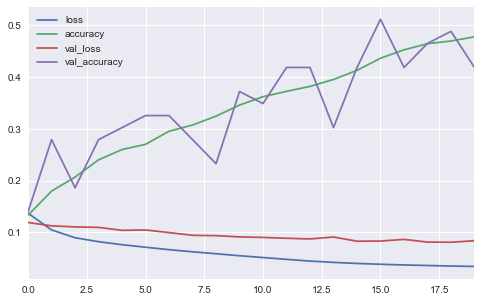

In [20]:
plot_train_history(evo_history,
                   'Training and validation loss')

43


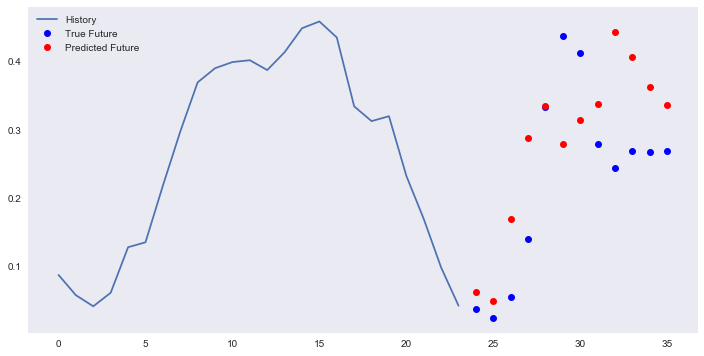

In [50]:
for x, y in evo_val.take(1):
    print(len(evo_model.predict(x)))
    multi_step_plot(x[0], y[0], evo_model.predict(x)[0])

## Modo model

In [51]:
print('Modo Model')
modo_model, modo_history = lstm_model(modo_train, modo_val, modo_shape, epochs=20)

Modo Model
(83, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 22s 110ms/step - loss: 0.0502 - accuracy: 0.1772 - val_loss: 0.0430 - val_accuracy: 0.3373
Epoch 2/20
200/200 [==============================] - 17s 83ms/step - loss: 0.0339 - accuracy: 0.2635 - val_loss: 0.0441 - val_accuracy: 0.2892
Epoch 3/20
200/200 [==============================] - 15s 76ms/step - loss: 0.0313 - accuracy: 0.2893 - val_loss: 0.0434 - val_accuracy: 0.3133
Epoch 4/20
200/200 [==============================] - 15s 74ms/step - loss: 0.0296 - accuracy: 0.3148 - val_loss: 0.0440 - val_accuracy: 0.3012
Epoch 5/20
200/200 [==============================] - 15s 73ms/step - loss: 0.0284 - accuracy: 0.3380 - val_loss: 0.0453 - val_accuracy: 0.2771
Epoch 6/20
200/200 [==============================] - 14s 72ms/step - loss: 0.0276 - accuracy: 0.3549 - val_loss: 0.0441 - val_accuracy: 0.2530
Epoch 7/20
200/200 [==============================] - 16s 81ms/step - lo

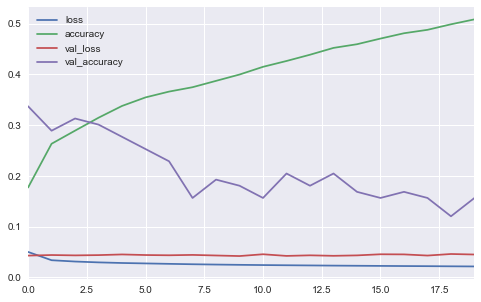

In [54]:
plot_train_history(modo_history,
                   'Training and validation loss')

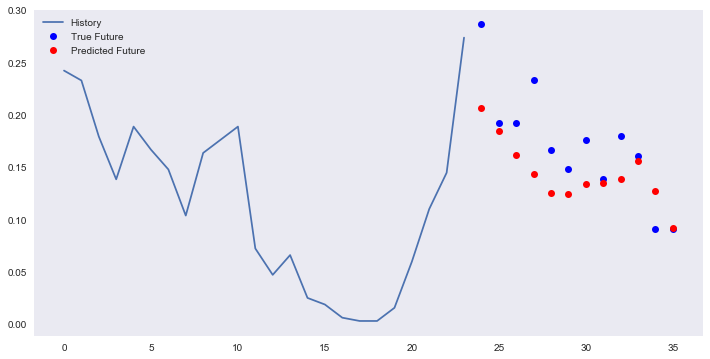

In [57]:
for x, y in modo_val.take(1):
    multi_step_plot(x[0], y[0], modo_model.predict(x)[0])

## Car2Go Model

In [ ]:
print('Car2Go Model')
c2g_model, c2g_history = lstm_model(c2g_train, c2g_val, c2g_shape, epochs=20)

Car2Go Model
(96, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 19s 97ms/step - loss: 0.1846 - accuracy: 0.1393 - val_loss: 0.1394 - val_accuracy: 0.3125
Epoch 2/20
200/200 [==============================] - 13s 64ms/step - loss: 0.1293 - accuracy: 0.2633 - val_loss: 0.1142 - val_accuracy: 0.2917
Epoch 3/20
200/200 [==============================] - 12s 59ms/step - loss: 0.1141 - accuracy: 0.3078 - val_loss: 0.1164 - val_accuracy: 0.2812
Epoch 4/20
200/200 [==============================] - 12s 60ms/step - loss: 0.1093 - accuracy: 0.3298 - val_loss: 0.1001 - val_accuracy: 0.3750
Epoch 5/20
200/200 [==============================] - 12s 62ms/step - loss: 0.1039 - accuracy: 0.3476 - val_loss: 0.1015 - val_accuracy: 0.3646
Epoch 6/20
200/200 [==============================] - 12s 61ms/step - loss: 0.1003 - accuracy: 0.3734 - val_loss: 0.0952 - val_accuracy: 0.4062
Epoch 7/20
200/200 [==============================] - 12s 61ms/step - l

In [ ]:
plot_train_history(c2g_history,
                   'Training and validation loss')

In [ ]:
for x, y in c2g_val.take(1):
    multi_step_plot(x[0], y[0],c2g_model.predict(x)[0])

### References

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/